# Error Analysis

In this notebook, we will be computing error histograms for the model: `c1e1-FastPitch-finetune` (Fine-tuned c1e1-FastPitch-pretrain on German emotional (openslr/110) dataset) per emotion!

Emotion ID mapping: {8:"neutral", 1:"amused", 2:"angry", 3:"disgusted", 4:"drunk", 5:"sleepy", 6:"surprised", 7:"whisper"}

Location of checkpoint: `/ngc_results_backup/emotionaltts/3244047-08142022_testc1e1_c1e2_ngc/c1e1-FastPitch-finetune/2022-08-15_22-07-51/checkpoints/c1e1-FastPitch-finetune.nemo`

In [7]:
# imports
import json
import numpy as np
from matplotlib import pyplot as plt

In [24]:
fmin = 65.40639132514966
fmax = 2093.004638671875
manifests={"test":"hifigan_test_manifest_phonemes_ft.json", "train":"hifigan_train_manifest_phonemes_ft.json", "val":"hifigan_val_manifest_phonemes_ft.json"}
target_mels_path = "/DataEmotionalTTS/thorsten-emotional_v02/orig_synmels999/"
predicted_mels_path = "/DataEmotionalTTS/thorsten-emotional_v02/synmels999_finalfp/"
emo_map = {8:"neutral", 1:"amused", 2:"angry", 3:"disgusted", 4:"drunk", 5:"sleepy", 6:"surprised", 7:"whisper"}


In [27]:
# methods

def extract_duration(manifest_path):
    durations = {}
    with open(manifest_path, "r") as f:
        for i, line in enumerate(f):
            line_dict = json.loads(line)
            mel_path = line_dict['mel_filepath']
            mel = np.load(mel_path)
            if line_dict['emotion_id'] in durations:
                durations[line_dict['emotion_id']].append(mel.shape[1])
            else:
                durations[line_dict['emotion_id']] = [mel.shape[1]]
    for key in durations:
        durations[key]=np.array(durations[key])
    return durations

def extract_pitch(manifest_path):
    pitch = []
    with open(manifest_path, "r") as f:
        for i, line in enumerate(f):
            line_dict = json.loads(line)
            mel_path = line_dict['mel_filepath']
            mel = np.load(mel_path)
            aud = librosa.feature.inverse.mel_to_audio(mel)
            pi,_,_ = librosa.pyin(aud, fmin=fmin, fmax=fmax)
            if line_dict['emotion_id'] in pitch:
                pitch[line_dict['emotion_id']].append(pi)
            else:
                pitch[line_dict['emotion_id']] = [pi]
    for key in pitch:
        pitch[key]=np.array(pitch[key])
    return pitch

def generate_error_histogram(manifest_A, manifest_B, durations=True, title=None):
    print("manifest_A: "+manifest_A)
    print("manifest_B: "+manifest_B)
    if durations:
        arr_A, arr_B = extract_duration(manifest_A), extract_duration(manifest_B)
    else:
        arr_A, arr_B = extract_pitch(manifest_A), extract_pitch(manifest_B)

    for em_key in emo_map:
        error = (arr_A[em_key] - arr_B[em_key])/arr_A[em_key]
        title_final = emo_map[em_key]+" "+title
        print("Mean: ", str(np.mean(error)))
        print("Variance: ", str(np.var(error)))
        bins = np.arange(-1,1.2,0.2)
        fig,ax = plt.subplots(1, 1)
        data_gen, bins_gen, _ = ax.hist(error, bins=bins)
        ax.set_title(title_final)
        ax.set_xticks(bins)
        if durations:
            ax.set_xlabel('(tar_mel_dur - pred_mel_dur) / tar_mel_dur')
        else:
            ax.set_xlabel('(tar_mel_pitch - pred_mel_pitch) / tar_mel_pitch')
        ax.set_ylabel('number of samples')
        plt.show()
        perfect_utterances = (error.shape[0] - np.count_nonzero(error))
        total_utterances = (error.shape[0])
        print("Number of utterances with 0.0 error: " + str(perfect_utterances) + " out of: " + str(total_utterances) + ". ~ " + str(round(perfect_utterances / total_utterances * 100, 4)) + "%")
        for i in range(len(bins_gen[:-1])):
            print("Between "+ str(round(bins_gen[i], 2)) +" and "+ str(round(bins_gen[i+1], 2)) +": " + str(data_gen[i]) + " out of: " + str(total_utterances) + ". ~ " + str(round(data_gen[i] / total_utterances * 100, 4)) + "%")

## Generate Original Synmels

In [5]:
import json
import numpy as np
import torch
import soundfile as sf
import librosa

from pathlib import Path

from nemo.collections.tts.torch.helpers import BetaBinomialInterpolator

folder_name = "orig_synmels999"
fastpitch_model_path = "/ngc_results_backup/emotionaltts/3244047-08142022_testc1e1_c1e2_ngc/c1e1-FastPitch-finetune/2022-08-15_22-07-51/checkpoints/c1e1-FastPitch-finetune.nemo"
dataset_parts = ["test_manifest_phonemes", "val_manifest_phonemes", "train_manifest_phonemes"]
dataset_base_path = "/DataEmotionalTTS/thorsten-emotional_v02/"


from nemo.collections.tts.models import FastPitchModel
if ".nemo" in fastpitch_model_path:
    spec_model = FastPitchModel.restore_from(fastpitch_model_path).eval().cuda()
else:
    spec_model = FastPitchModel.load_from_checkpoint(checkpoint_path=fastpitch_model_path).eval().cuda()

spec_model.eval().cuda()
    
def load_wav(audio_file):
    with sf.SoundFile(audio_file, 'r') as f:
        samples = f.read(dtype='float32')
    return samples.transpose()
    
for dataset_part in dataset_parts:
    # Get records from the manifest
    manifest_path = f"{dataset_base_path}{dataset_part}.json"
    records = []
    with open(manifest_path, "r") as f:
        for i, line in enumerate(f):
            records.append(json.loads(line))

    beta_binomial_interpolator = BetaBinomialInterpolator()

    spec_model.eval()
    device = spec_model.device

    save_dir = Path(f"{dataset_base_path}{folder_name}/{dataset_part}")

    save_dir.mkdir(exist_ok=True, parents=True)

    # Generate a spectrograms (we need to use ground truth alignment for correct matching between audio and mels)
    for i, r in enumerate(records):
        audio = load_wav(r["audio_filepath"])

        audio = torch.from_numpy(audio).unsqueeze(0).to(device)
        audio_len = torch.tensor(audio.shape[1], dtype=torch.long, device=device).unsqueeze(0)

        # Again, our finetuned FastPitch model doesn't use multiple speakers,
        # but we keep the code to support it here for reference
        if spec_model.fastpitch.speaker_emb is not None and "speaker" in r:
            speaker = torch.tensor([r['speaker']]).to(device)
        else:
            speaker = None
            
        if spec_model.fastpitch.emotion_emb is not None and "emotion_id" in r:
            emotion = torch.tensor([r['emotion_id']]).to(device)
        else:
            emotion = None

        with torch.no_grad():
            if "normalized_text" in r:
                text = spec_model.parse(r["normalized_text"], normalize=False)
            else:
                text = spec_model.parse(r['text'])
        
            spectrogram = spec_model.generate_spectrogram(
              tokens=text, 
              emotion=emotion
            )

        save_path = save_dir / f"mel_{i}.npy"
        np.save(save_path, spectrogram[0].to('cpu').numpy())
        r["mel_filepath"] = str(save_path)

        hifigan_manifest_path = f"{dataset_base_path}{folder_name}/hifigan_{dataset_part}_ft.json"

        with open(hifigan_manifest_path, "w") as f:
            for r in records:
                f.write(json.dumps(r) + '\n')

[NeMo W 2022-09-08 00:57:38 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/apex/pyprof/__init__.py:5: FutureWarning: pyprof will be removed by the end of June, 2022
      warnings.warn("pyprof will be removed by the end of June, 2022", FutureWarning)
    
[NeMo W 2022-09-08 00:57:39 experimental:27] Module <class 'nemo.collections.tts.torch.tts_tokenizers.IPATokenizer'> is experimental, not ready for production and is not fully supported. Use at your own risk.


[NeMo I 2022-09-08 00:57:40 tokenize_and_classify:81] Creating ClassifyFst grammars. This might take some time...


[NeMo W 2022-09-08 00:57:57 modelPT:149] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.TTSDataset
      manifest_filepath: /DataEmotionalTTS/thorsten-emotional_v02/train_manifest_phonemes.json
      sample_rate: 22050
      sup_data_path: /DataEmotionalTTS/thorsten-emotional_v02/phonemes/
      sup_data_types:
      - align_prior_matrix
      - pitch
      - emotion_id
      n_fft: 1024
      win_length: 1024
      hop_length: 256
      window: hann
      n_mels: 80
      lowfreq: 0
      highfreq: null
      max_duration: 14
      min_duration: 0.1
      ignore_file: null
      trim: false
      pitch_fmin: 65.40639132514966
      pitch_fmax: 2093.004638671875
      pitch_norm: true
      pitch_mean: 169.59390258789062
      pitch_std: 103.64842224121094
      use_beta_binomial_interp

[NeMo I 2022-09-08 00:57:57 features:200] PADDING: 1
[NeMo I 2022-09-08 00:57:59 save_restore_connector:243] Model FastPitchModel was successfully restored from /ngc_results_backup/emotionaltts/3244047-08142022_testc1e1_c1e2_ngc/c1e1-FastPitch-finetune/2022-08-15_22-07-51/checkpoints/c1e1-FastPitch-finetune.nemo.


[NeMo W 2022-09-08 00:58:02 tts_tokenizers:144] Text: [viː ʃɛtsən ziː diː ʃɑ̃sən aɪn zoː aɪnən pɾoːtsɛs tsuː ɡəvɪnən ] contains unknown char: [̃]. Symbol will be skipped.
[NeMo W 2022-09-08 00:58:07 tts_tokenizers:144] Text: [viː ʃɛtsən ziː diː ʃɑ̃sən aɪn zoː aɪnən pɾoːtsɛs tsuː ɡəvɪnən ] contains unknown char: [̃]. Symbol will be skipped.
[NeMo W 2022-09-08 00:58:18 tts_tokenizers:144] Text: [viː ʃɛtsən ziː diː ʃɑ̃sən aɪn zoː aɪnən pɾoːtsɛs tsuː ɡəvɪnən ] contains unknown char: [̃]. Symbol will be skipped.
[NeMo W 2022-09-08 00:58:42 tts_tokenizers:144] Text: [viː ʃɛtsən ziː diː ʃɑ̃sən aɪn zoː aɪnən pɾoːtsɛs tsuː ɡəvɪnən ] contains unknown char: [̃]. Symbol will be skipped.
[NeMo W 2022-09-08 00:58:48 tts_tokenizers:144] Text: [viː ʃɛtsən ziː diː ʃɑ̃sən aɪn zoː aɪnən pɾoːtsɛs tsuː ɡəvɪnən ] contains unknown char: [̃]. Symbol will be skipped.
[NeMo W 2022-09-08 00:58:53 tts_tokenizers:144] Text: [viː ʃɛtsən ziː diː ʃɑ̃sən aɪn zoː aɪnən pɾoːtsɛs tsuː ɡəvɪnən ] contains unknown char: [̃]

## Pitch Errors

In [20]:
for key in manifests.keys():
    print("Generating "+key+" set histogram")
    generate_error_histogram(target_mels_path+manifests[key], predicted_mels_path+manifests[key], durations=False, title=key+" set histogram for pitch errors")
    

Generating test set histogram
manifest_A: /DataEmotionalTTS/thorsten-emotional_v02/orig_synmels999/hifigan_test_manifest_phonemes_ft.json
manifest_B: /DataEmotionalTTS/thorsten-emotional_v02/synmels999_finalfp/hifigan_test_manifest_phonemes_ft.json


KeyboardInterrupt: 

## Duration Errors

Generating test set histogram
manifest_A: /DataEmotionalTTS/thorsten-emotional_v02/orig_synmels999/hifigan_test_manifest_phonemes_ft.json
manifest_B: /DataEmotionalTTS/thorsten-emotional_v02/synmels999_finalfp/hifigan_test_manifest_phonemes_ft.json
Mean:  -0.05172047772374032
Variance:  0.005384252175063452


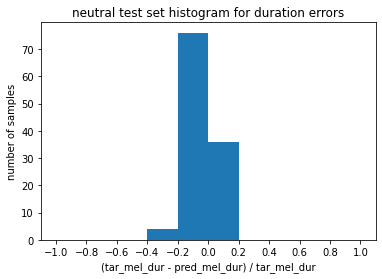

Number of utterances with 0.0 error: 3 out of: 116. ~ 2.5862%
Between -1.0 and -0.8: 0.0 out of: 116. ~ 0.0%
Between -0.8 and -0.6: 0.0 out of: 116. ~ 0.0%
Between -0.6 and -0.4: 0.0 out of: 116. ~ 0.0%
Between -0.4 and -0.2: 4.0 out of: 116. ~ 3.4483%
Between -0.2 and -0.0: 76.0 out of: 116. ~ 65.5172%
Between -0.0 and 0.2: 36.0 out of: 116. ~ 31.0345%
Between 0.2 and 0.4: 0.0 out of: 116. ~ 0.0%
Between 0.4 and 0.6: 0.0 out of: 116. ~ 0.0%
Between 0.6 and 0.8: 0.0 out of: 116. ~ 0.0%
Between 0.8 and 1.0: 0.0 out of: 116. ~ 0.0%
Mean:  -0.05446538755884011
Variance:  0.0038574769437191856


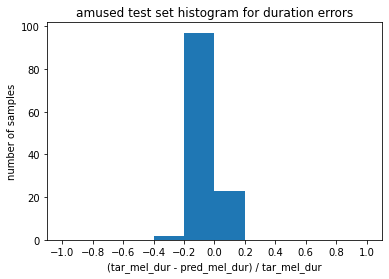

Number of utterances with 0.0 error: 5 out of: 122. ~ 4.0984%
Between -1.0 and -0.8: 0.0 out of: 122. ~ 0.0%
Between -0.8 and -0.6: 0.0 out of: 122. ~ 0.0%
Between -0.6 and -0.4: 0.0 out of: 122. ~ 0.0%
Between -0.4 and -0.2: 2.0 out of: 122. ~ 1.6393%
Between -0.2 and -0.0: 97.0 out of: 122. ~ 79.5082%
Between -0.0 and 0.2: 23.0 out of: 122. ~ 18.8525%
Between 0.2 and 0.4: 0.0 out of: 122. ~ 0.0%
Between 0.4 and 0.6: 0.0 out of: 122. ~ 0.0%
Between 0.6 and 0.8: 0.0 out of: 122. ~ 0.0%
Between 0.8 and 1.0: 0.0 out of: 122. ~ 0.0%
Mean:  -0.055364249760077124
Variance:  0.011925952026871486


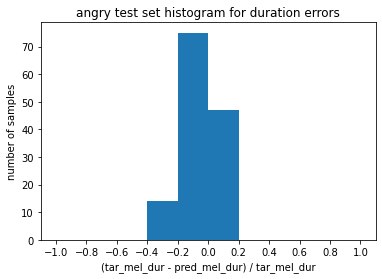

Number of utterances with 0.0 error: 2 out of: 136. ~ 1.4706%
Between -1.0 and -0.8: 0.0 out of: 136. ~ 0.0%
Between -0.8 and -0.6: 0.0 out of: 136. ~ 0.0%
Between -0.6 and -0.4: 0.0 out of: 136. ~ 0.0%
Between -0.4 and -0.2: 14.0 out of: 136. ~ 10.2941%
Between -0.2 and -0.0: 75.0 out of: 136. ~ 55.1471%
Between -0.0 and 0.2: 47.0 out of: 136. ~ 34.5588%
Between 0.2 and 0.4: 0.0 out of: 136. ~ 0.0%
Between 0.4 and 0.6: 0.0 out of: 136. ~ 0.0%
Between 0.6 and 0.8: 0.0 out of: 136. ~ 0.0%
Between 0.8 and 1.0: 0.0 out of: 136. ~ 0.0%
Mean:  -0.046326912965994366
Variance:  0.009874406019304009


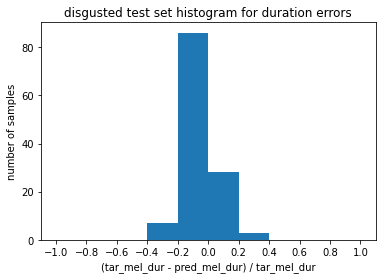

Number of utterances with 0.0 error: 2 out of: 124. ~ 1.6129%
Between -1.0 and -0.8: 0.0 out of: 124. ~ 0.0%
Between -0.8 and -0.6: 0.0 out of: 124. ~ 0.0%
Between -0.6 and -0.4: 0.0 out of: 124. ~ 0.0%
Between -0.4 and -0.2: 7.0 out of: 124. ~ 5.6452%
Between -0.2 and -0.0: 86.0 out of: 124. ~ 69.3548%
Between -0.0 and 0.2: 28.0 out of: 124. ~ 22.5806%
Between 0.2 and 0.4: 3.0 out of: 124. ~ 2.4194%
Between 0.4 and 0.6: 0.0 out of: 124. ~ 0.0%
Between 0.6 and 0.8: 0.0 out of: 124. ~ 0.0%
Between 0.8 and 1.0: 0.0 out of: 124. ~ 0.0%
Mean:  -0.079531588062723
Variance:  0.008731988303080284


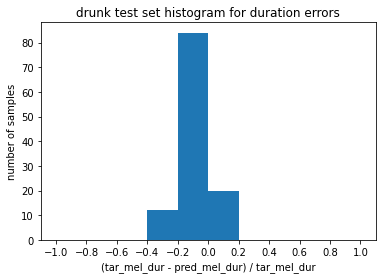

Number of utterances with 0.0 error: 1 out of: 116. ~ 0.8621%
Between -1.0 and -0.8: 0.0 out of: 116. ~ 0.0%
Between -0.8 and -0.6: 0.0 out of: 116. ~ 0.0%
Between -0.6 and -0.4: 0.0 out of: 116. ~ 0.0%
Between -0.4 and -0.2: 12.0 out of: 116. ~ 10.3448%
Between -0.2 and -0.0: 84.0 out of: 116. ~ 72.4138%
Between -0.0 and 0.2: 20.0 out of: 116. ~ 17.2414%
Between 0.2 and 0.4: 0.0 out of: 116. ~ 0.0%
Between 0.4 and 0.6: 0.0 out of: 116. ~ 0.0%
Between 0.6 and 0.8: 0.0 out of: 116. ~ 0.0%
Between 0.8 and 1.0: 0.0 out of: 116. ~ 0.0%
Mean:  -0.044719556963809595
Variance:  0.0064098004518611


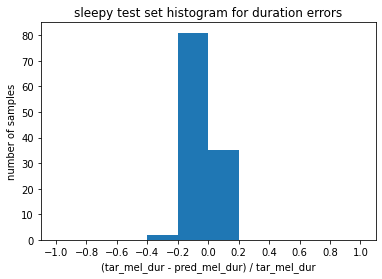

Number of utterances with 0.0 error: 1 out of: 118. ~ 0.8475%
Between -1.0 and -0.8: 0.0 out of: 118. ~ 0.0%
Between -0.8 and -0.6: 0.0 out of: 118. ~ 0.0%
Between -0.6 and -0.4: 0.0 out of: 118. ~ 0.0%
Between -0.4 and -0.2: 2.0 out of: 118. ~ 1.6949%
Between -0.2 and -0.0: 81.0 out of: 118. ~ 68.6441%
Between -0.0 and 0.2: 35.0 out of: 118. ~ 29.661%
Between 0.2 and 0.4: 0.0 out of: 118. ~ 0.0%
Between 0.4 and 0.6: 0.0 out of: 118. ~ 0.0%
Between 0.6 and 0.8: 0.0 out of: 118. ~ 0.0%
Between 0.8 and 1.0: 0.0 out of: 118. ~ 0.0%
Mean:  -0.0773730738022255
Variance:  0.004589025484579018


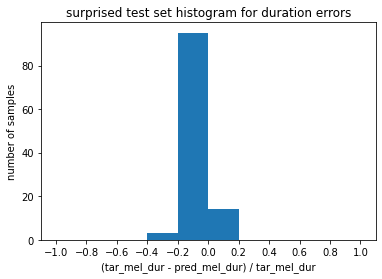

Number of utterances with 0.0 error: 0 out of: 112. ~ 0.0%
Between -1.0 and -0.8: 0.0 out of: 112. ~ 0.0%
Between -0.8 and -0.6: 0.0 out of: 112. ~ 0.0%
Between -0.6 and -0.4: 0.0 out of: 112. ~ 0.0%
Between -0.4 and -0.2: 3.0 out of: 112. ~ 2.6786%
Between -0.2 and -0.0: 95.0 out of: 112. ~ 84.8214%
Between -0.0 and 0.2: 14.0 out of: 112. ~ 12.5%
Between 0.2 and 0.4: 0.0 out of: 112. ~ 0.0%
Between 0.4 and 0.6: 0.0 out of: 112. ~ 0.0%
Between 0.6 and 0.8: 0.0 out of: 112. ~ 0.0%
Between 0.8 and 1.0: 0.0 out of: 112. ~ 0.0%
Mean:  -0.04969916462922415
Variance:  0.0038075315244652176


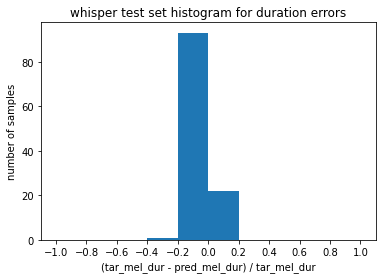

Number of utterances with 0.0 error: 1 out of: 116. ~ 0.8621%
Between -1.0 and -0.8: 0.0 out of: 116. ~ 0.0%
Between -0.8 and -0.6: 0.0 out of: 116. ~ 0.0%
Between -0.6 and -0.4: 0.0 out of: 116. ~ 0.0%
Between -0.4 and -0.2: 1.0 out of: 116. ~ 0.8621%
Between -0.2 and -0.0: 93.0 out of: 116. ~ 80.1724%
Between -0.0 and 0.2: 22.0 out of: 116. ~ 18.9655%
Between 0.2 and 0.4: 0.0 out of: 116. ~ 0.0%
Between 0.4 and 0.6: 0.0 out of: 116. ~ 0.0%
Between 0.6 and 0.8: 0.0 out of: 116. ~ 0.0%
Between 0.8 and 1.0: 0.0 out of: 116. ~ 0.0%
Generating train set histogram
manifest_A: /DataEmotionalTTS/thorsten-emotional_v02/orig_synmels999/hifigan_train_manifest_phonemes_ft.json
manifest_B: /DataEmotionalTTS/thorsten-emotional_v02/synmels999_finalfp/hifigan_train_manifest_phonemes_ft.json
Mean:  -0.0008655870158429211
Variance:  0.00011295099180955042


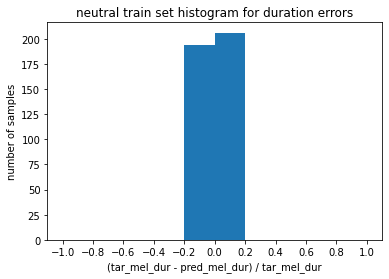

Number of utterances with 0.0 error: 56 out of: 400. ~ 14.0%
Between -1.0 and -0.8: 0.0 out of: 400. ~ 0.0%
Between -0.8 and -0.6: 0.0 out of: 400. ~ 0.0%
Between -0.6 and -0.4: 0.0 out of: 400. ~ 0.0%
Between -0.4 and -0.2: 0.0 out of: 400. ~ 0.0%
Between -0.2 and -0.0: 194.0 out of: 400. ~ 48.5%
Between -0.0 and 0.2: 206.0 out of: 400. ~ 51.5%
Between 0.2 and 0.4: 0.0 out of: 400. ~ 0.0%
Between 0.4 and 0.6: 0.0 out of: 400. ~ 0.0%
Between 0.6 and 0.8: 0.0 out of: 400. ~ 0.0%
Between 0.8 and 1.0: 0.0 out of: 400. ~ 0.0%
Mean:  -0.004795375235023917
Variance:  0.00012010343443821648


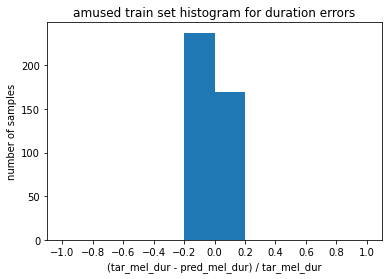

Number of utterances with 0.0 error: 70 out of: 406. ~ 17.2414%
Between -1.0 and -0.8: 0.0 out of: 406. ~ 0.0%
Between -0.8 and -0.6: 0.0 out of: 406. ~ 0.0%
Between -0.6 and -0.4: 0.0 out of: 406. ~ 0.0%
Between -0.4 and -0.2: 0.0 out of: 406. ~ 0.0%
Between -0.2 and -0.0: 237.0 out of: 406. ~ 58.3744%
Between -0.0 and 0.2: 169.0 out of: 406. ~ 41.6256%
Between 0.2 and 0.4: 0.0 out of: 406. ~ 0.0%
Between 0.4 and 0.6: 0.0 out of: 406. ~ 0.0%
Between 0.6 and 0.8: 0.0 out of: 406. ~ 0.0%
Between 0.8 and 1.0: 0.0 out of: 406. ~ 0.0%
Mean:  -0.000122998058930411
Variance:  0.00010159523752378193


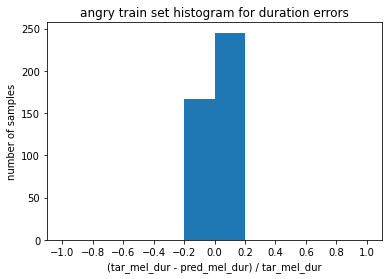

Number of utterances with 0.0 error: 78 out of: 412. ~ 18.932%
Between -1.0 and -0.8: 0.0 out of: 412. ~ 0.0%
Between -0.8 and -0.6: 0.0 out of: 412. ~ 0.0%
Between -0.6 and -0.4: 0.0 out of: 412. ~ 0.0%
Between -0.4 and -0.2: 0.0 out of: 412. ~ 0.0%
Between -0.2 and -0.0: 167.0 out of: 412. ~ 40.534%
Between -0.0 and 0.2: 245.0 out of: 412. ~ 59.466%
Between 0.2 and 0.4: 0.0 out of: 412. ~ 0.0%
Between 0.4 and 0.6: 0.0 out of: 412. ~ 0.0%
Between 0.6 and 0.8: 0.0 out of: 412. ~ 0.0%
Between 0.8 and 1.0: 0.0 out of: 412. ~ 0.0%
Mean:  -0.0023340767444904324
Variance:  0.00011874380913487401


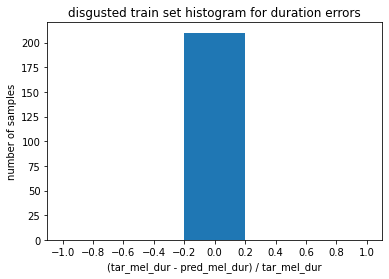

Number of utterances with 0.0 error: 51 out of: 420. ~ 12.1429%
Between -1.0 and -0.8: 0.0 out of: 420. ~ 0.0%
Between -0.8 and -0.6: 0.0 out of: 420. ~ 0.0%
Between -0.6 and -0.4: 0.0 out of: 420. ~ 0.0%
Between -0.4 and -0.2: 0.0 out of: 420. ~ 0.0%
Between -0.2 and -0.0: 210.0 out of: 420. ~ 50.0%
Between -0.0 and 0.2: 210.0 out of: 420. ~ 50.0%
Between 0.2 and 0.4: 0.0 out of: 420. ~ 0.0%
Between 0.4 and 0.6: 0.0 out of: 420. ~ 0.0%
Between 0.6 and 0.8: 0.0 out of: 420. ~ 0.0%
Between 0.8 and 1.0: 0.0 out of: 420. ~ 0.0%
Mean:  0.0025085285782340486
Variance:  0.0010692211089823773


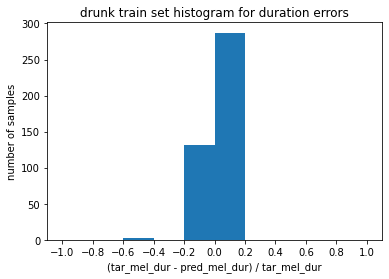

Number of utterances with 0.0 error: 36 out of: 420. ~ 8.5714%
Between -1.0 and -0.8: 0.0 out of: 420. ~ 0.0%
Between -0.8 and -0.6: 0.0 out of: 420. ~ 0.0%
Between -0.6 and -0.4: 2.0 out of: 420. ~ 0.4762%
Between -0.4 and -0.2: 0.0 out of: 420. ~ 0.0%
Between -0.2 and -0.0: 131.0 out of: 420. ~ 31.1905%
Between -0.0 and 0.2: 287.0 out of: 420. ~ 68.3333%
Between 0.2 and 0.4: 0.0 out of: 420. ~ 0.0%
Between 0.4 and 0.6: 0.0 out of: 420. ~ 0.0%
Between 0.6 and 0.8: 0.0 out of: 420. ~ 0.0%
Between 0.8 and 1.0: 0.0 out of: 420. ~ 0.0%
Mean:  0.0009698803359748778
Variance:  0.00012709637727855572


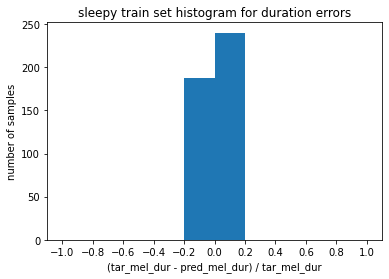

Number of utterances with 0.0 error: 36 out of: 428. ~ 8.4112%
Between -1.0 and -0.8: 0.0 out of: 428. ~ 0.0%
Between -0.8 and -0.6: 0.0 out of: 428. ~ 0.0%
Between -0.6 and -0.4: 0.0 out of: 428. ~ 0.0%
Between -0.4 and -0.2: 0.0 out of: 428. ~ 0.0%
Between -0.2 and -0.0: 188.0 out of: 428. ~ 43.9252%
Between -0.0 and 0.2: 240.0 out of: 428. ~ 56.0748%
Between 0.2 and 0.4: 0.0 out of: 428. ~ 0.0%
Between 0.4 and 0.6: 0.0 out of: 428. ~ 0.0%
Between 0.6 and 0.8: 0.0 out of: 428. ~ 0.0%
Between 0.8 and 1.0: 0.0 out of: 428. ~ 0.0%
Mean:  -0.007250432020389387
Variance:  0.00010413216260849374


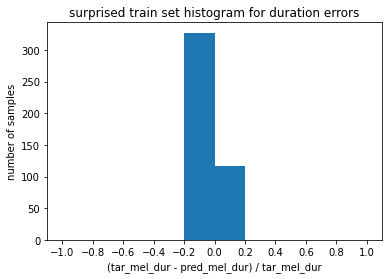

Number of utterances with 0.0 error: 50 out of: 444. ~ 11.2613%
Between -1.0 and -0.8: 0.0 out of: 444. ~ 0.0%
Between -0.8 and -0.6: 0.0 out of: 444. ~ 0.0%
Between -0.6 and -0.4: 0.0 out of: 444. ~ 0.0%
Between -0.4 and -0.2: 0.0 out of: 444. ~ 0.0%
Between -0.2 and -0.0: 327.0 out of: 444. ~ 73.6486%
Between -0.0 and 0.2: 117.0 out of: 444. ~ 26.3514%
Between 0.2 and 0.4: 0.0 out of: 444. ~ 0.0%
Between 0.4 and 0.6: 0.0 out of: 444. ~ 0.0%
Between 0.6 and 0.8: 0.0 out of: 444. ~ 0.0%
Between 0.8 and 1.0: 0.0 out of: 444. ~ 0.0%
Mean:  -0.007817692182519943
Variance:  0.00025627083907797806


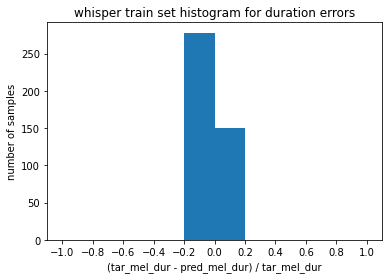

Number of utterances with 0.0 error: 45 out of: 428. ~ 10.514%
Between -1.0 and -0.8: 0.0 out of: 428. ~ 0.0%
Between -0.8 and -0.6: 0.0 out of: 428. ~ 0.0%
Between -0.6 and -0.4: 0.0 out of: 428. ~ 0.0%
Between -0.4 and -0.2: 0.0 out of: 428. ~ 0.0%
Between -0.2 and -0.0: 278.0 out of: 428. ~ 64.9533%
Between -0.0 and 0.2: 150.0 out of: 428. ~ 35.0467%
Between 0.2 and 0.4: 0.0 out of: 428. ~ 0.0%
Between 0.4 and 0.6: 0.0 out of: 428. ~ 0.0%
Between 0.6 and 0.8: 0.0 out of: 428. ~ 0.0%
Between 0.8 and 1.0: 0.0 out of: 428. ~ 0.0%
Generating val set histogram
manifest_A: /DataEmotionalTTS/thorsten-emotional_v02/orig_synmels999/hifigan_val_manifest_phonemes_ft.json
manifest_B: /DataEmotionalTTS/thorsten-emotional_v02/synmels999_finalfp/hifigan_val_manifest_phonemes_ft.json
Mean:  -0.04826446678728505
Variance:  0.004767067523823244


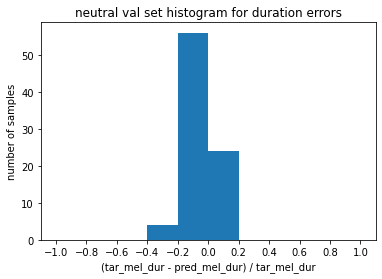

Number of utterances with 0.0 error: 2 out of: 84. ~ 2.381%
Between -1.0 and -0.8: 0.0 out of: 84. ~ 0.0%
Between -0.8 and -0.6: 0.0 out of: 84. ~ 0.0%
Between -0.6 and -0.4: 0.0 out of: 84. ~ 0.0%
Between -0.4 and -0.2: 4.0 out of: 84. ~ 4.7619%
Between -0.2 and -0.0: 56.0 out of: 84. ~ 66.6667%
Between -0.0 and 0.2: 24.0 out of: 84. ~ 28.5714%
Between 0.2 and 0.4: 0.0 out of: 84. ~ 0.0%
Between 0.4 and 0.6: 0.0 out of: 84. ~ 0.0%
Between 0.6 and 0.8: 0.0 out of: 84. ~ 0.0%
Between 0.8 and 1.0: 0.0 out of: 84. ~ 0.0%
Mean:  -0.06527389176098367
Variance:  0.003549167310507204


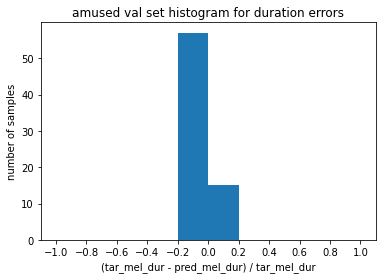

Number of utterances with 0.0 error: 2 out of: 72. ~ 2.7778%
Between -1.0 and -0.8: 0.0 out of: 72. ~ 0.0%
Between -0.8 and -0.6: 0.0 out of: 72. ~ 0.0%
Between -0.6 and -0.4: 0.0 out of: 72. ~ 0.0%
Between -0.4 and -0.2: 0.0 out of: 72. ~ 0.0%
Between -0.2 and -0.0: 57.0 out of: 72. ~ 79.1667%
Between -0.0 and 0.2: 15.0 out of: 72. ~ 20.8333%
Between 0.2 and 0.4: 0.0 out of: 72. ~ 0.0%
Between 0.4 and 0.6: 0.0 out of: 72. ~ 0.0%
Between 0.6 and 0.8: 0.0 out of: 72. ~ 0.0%
Between 0.8 and 1.0: 0.0 out of: 72. ~ 0.0%
Mean:  -0.08167425423784368
Variance:  0.011752972668601057


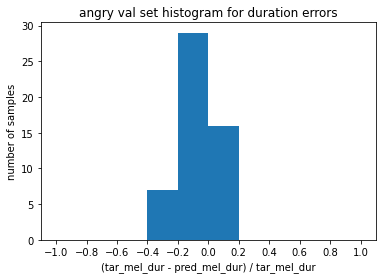

Number of utterances with 0.0 error: 0 out of: 52. ~ 0.0%
Between -1.0 and -0.8: 0.0 out of: 52. ~ 0.0%
Between -0.8 and -0.6: 0.0 out of: 52. ~ 0.0%
Between -0.6 and -0.4: 0.0 out of: 52. ~ 0.0%
Between -0.4 and -0.2: 7.0 out of: 52. ~ 13.4615%
Between -0.2 and -0.0: 29.0 out of: 52. ~ 55.7692%
Between -0.0 and 0.2: 16.0 out of: 52. ~ 30.7692%
Between 0.2 and 0.4: 0.0 out of: 52. ~ 0.0%
Between 0.4 and 0.6: 0.0 out of: 52. ~ 0.0%
Between 0.6 and 0.8: 0.0 out of: 52. ~ 0.0%
Between 0.8 and 1.0: 0.0 out of: 52. ~ 0.0%
Mean:  -0.05395708613439608
Variance:  0.003438119981047676


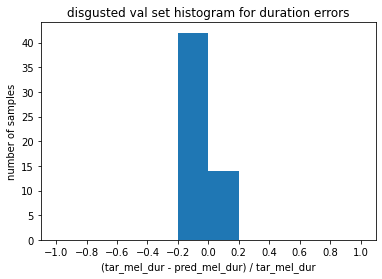

Number of utterances with 0.0 error: 1 out of: 56. ~ 1.7857%
Between -1.0 and -0.8: 0.0 out of: 56. ~ 0.0%
Between -0.8 and -0.6: 0.0 out of: 56. ~ 0.0%
Between -0.6 and -0.4: 0.0 out of: 56. ~ 0.0%
Between -0.4 and -0.2: 0.0 out of: 56. ~ 0.0%
Between -0.2 and -0.0: 42.0 out of: 56. ~ 75.0%
Between -0.0 and 0.2: 14.0 out of: 56. ~ 25.0%
Between 0.2 and 0.4: 0.0 out of: 56. ~ 0.0%
Between 0.4 and 0.6: 0.0 out of: 56. ~ 0.0%
Between 0.6 and 0.8: 0.0 out of: 56. ~ 0.0%
Between 0.8 and 1.0: 0.0 out of: 56. ~ 0.0%
Mean:  -0.07399776279767276
Variance:  0.006413214106595202


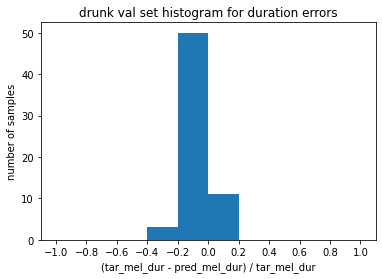

Number of utterances with 0.0 error: 0 out of: 64. ~ 0.0%
Between -1.0 and -0.8: 0.0 out of: 64. ~ 0.0%
Between -0.8 and -0.6: 0.0 out of: 64. ~ 0.0%
Between -0.6 and -0.4: 0.0 out of: 64. ~ 0.0%
Between -0.4 and -0.2: 3.0 out of: 64. ~ 4.6875%
Between -0.2 and -0.0: 50.0 out of: 64. ~ 78.125%
Between -0.0 and 0.2: 11.0 out of: 64. ~ 17.1875%
Between 0.2 and 0.4: 0.0 out of: 64. ~ 0.0%
Between 0.4 and 0.6: 0.0 out of: 64. ~ 0.0%
Between 0.6 and 0.8: 0.0 out of: 64. ~ 0.0%
Between 0.8 and 1.0: 0.0 out of: 64. ~ 0.0%
Mean:  -0.0695325425922612
Variance:  0.0066730660246261345


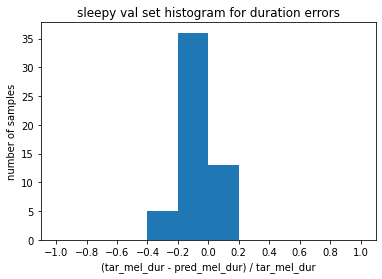

Number of utterances with 0.0 error: 2 out of: 54. ~ 3.7037%
Between -1.0 and -0.8: 0.0 out of: 54. ~ 0.0%
Between -0.8 and -0.6: 0.0 out of: 54. ~ 0.0%
Between -0.6 and -0.4: 0.0 out of: 54. ~ 0.0%
Between -0.4 and -0.2: 5.0 out of: 54. ~ 9.2593%
Between -0.2 and -0.0: 36.0 out of: 54. ~ 66.6667%
Between -0.0 and 0.2: 13.0 out of: 54. ~ 24.0741%
Between 0.2 and 0.4: 0.0 out of: 54. ~ 0.0%
Between 0.4 and 0.6: 0.0 out of: 54. ~ 0.0%
Between 0.6 and 0.8: 0.0 out of: 54. ~ 0.0%
Between 0.8 and 1.0: 0.0 out of: 54. ~ 0.0%
Mean:  -0.05025954857556178
Variance:  0.00326935861132174


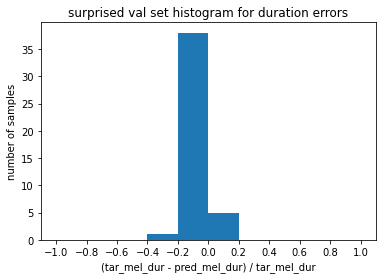

Number of utterances with 0.0 error: 0 out of: 44. ~ 0.0%
Between -1.0 and -0.8: 0.0 out of: 44. ~ 0.0%
Between -0.8 and -0.6: 0.0 out of: 44. ~ 0.0%
Between -0.6 and -0.4: 0.0 out of: 44. ~ 0.0%
Between -0.4 and -0.2: 1.0 out of: 44. ~ 2.2727%
Between -0.2 and -0.0: 38.0 out of: 44. ~ 86.3636%
Between -0.0 and 0.2: 5.0 out of: 44. ~ 11.3636%
Between 0.2 and 0.4: 0.0 out of: 44. ~ 0.0%
Between 0.4 and 0.6: 0.0 out of: 44. ~ 0.0%
Between 0.6 and 0.8: 0.0 out of: 44. ~ 0.0%
Between 0.8 and 1.0: 0.0 out of: 44. ~ 0.0%
Mean:  -0.045717535738940406
Variance:  0.004838091094741747


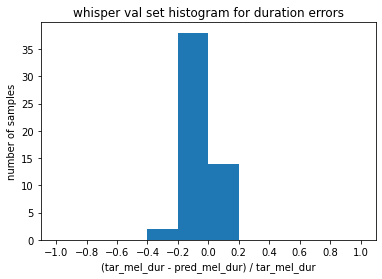

Number of utterances with 0.0 error: 0 out of: 54. ~ 0.0%
Between -1.0 and -0.8: 0.0 out of: 54. ~ 0.0%
Between -0.8 and -0.6: 0.0 out of: 54. ~ 0.0%
Between -0.6 and -0.4: 0.0 out of: 54. ~ 0.0%
Between -0.4 and -0.2: 2.0 out of: 54. ~ 3.7037%
Between -0.2 and -0.0: 38.0 out of: 54. ~ 70.3704%
Between -0.0 and 0.2: 14.0 out of: 54. ~ 25.9259%
Between 0.2 and 0.4: 0.0 out of: 54. ~ 0.0%
Between 0.4 and 0.6: 0.0 out of: 54. ~ 0.0%
Between 0.6 and 0.8: 0.0 out of: 54. ~ 0.0%
Between 0.8 and 1.0: 0.0 out of: 54. ~ 0.0%


In [28]:
for key in manifests.keys():
    print("Generating "+key+" set histogram")
    generate_error_histogram(target_mels_path+manifests[key], predicted_mels_path+manifests[key], durations=True, title=key+" set histogram for duration errors")
    